# 1.1) Source Code

In [1]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant

### 데이터 준비

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

- train_data 와 test_data 를 준비합니다

In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


***

### 사용 함수

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 데이터 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)    # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords]    # 불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)    # 토큰화
        temp_X = [word for word in temp_X if word not in stopwords]    # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()    # X_train 을 list 로 변환
    counter = Counter(words)    # 각 단어의 개수를 count
    counter = counter.most_common(10000-4)    # 가장 개수가 많은 9996 개의 단어 추출 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]    # 10000 개의 단어를 vocab 리스트에 저장
    word_to_index = {word:index for index, word in enumerate(vocab)}    # 단어장 생성
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

- load_data() 는 불러온 dataset 의 document 컬럼에서 중복값 및 결측값을 제거합니다.
- 이후, 각 문장을 토큰화하고 stopwords 내 단어는 제거합니다.
- 또한, Counter() 를 사용해 중복되는 단어를 제외하고 단어장을 생성합니다.
- dataset 의 문장들을 단어장을 활용해 텐서로 변환해줍니다.
- dataset 의 label 컬럼은 0 과 1의 target 변수이므로, y 가 됩니다.
- 결론적으로, 텐서로 변환된 문장들(X_train, X_test), 라벨(y_train, y_test), 단어장(word_to_index) 를 반환합니다.

In [5]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

- 문장 1 개를 단어장과 함께 인자로 주면, 텐서로 변환해주는 함수입니다.
- 문장의 앞에 \'\<BOS>' 를 추가합니다.

In [6]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

- 여러 개의 문장 리스트를 한 번에 텐서로 변환해주는 함수입니다.
- 문장의 앞에 \'\<BOS>' 를 추가합니다.

In [7]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence)

- 텐서로 변환된 문장을 다시 복원하는 함수입니다.

In [8]:
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

- 여러 개의 텐서 문장을 다시 복원하는 함수입니다.

***

### 데이터 전처리

In [9]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

- 앞서 정의한 load_data() 로 X_train, y_train, X_test, y_test, 단어장을 생성합니다.

In [10]:
print("len(X_train)", len(X_train))
print("len(y_train)", len(y_train))
print("len(X_test)", len(X_test))
print("len(y_test)", len(y_test))
print("len(word_to_index)", len(word_to_index))

len(X_train) 146182
len(y_train) 146182
len(X_test) 49157
len(y_test) 49157
len(word_to_index) 10000


- X_train 과 X_test 는 Tensor 형태의 문장입니다.
- y_train 과 y_test 는 0 과 1의 라벨입니다.

In [11]:
# Test
print("word_to_index['<PAD>'] =", word_to_index['<PAD>'])
print("word_to_index['<BOS>'] =", word_to_index['<BOS>'])
print("word_to_index['<UNK>'] =", word_to_index['<UNK>'])
print("word_to_index['<UNUSED>'] =", word_to_index['<UNUSED>'])

word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2
word_to_index['<UNUSED>'] = 3


- word_to_index 에는 pad 와 bos, unk 가 이미 정의되어 있습니다.

In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

# Test
print(index_to_word[0])
print(word_to_index['<PAD>'])
print(index_to_word[1])
print(word_to_index['<BOS>'])
print(len(word_to_index))
print(len(index_to_word))

<PAD>
0
<BOS>
1
10000
10000


- word_to_index 를 활용하여 index_to_word 를 생성합니다.

In [13]:
print(X_train[0])
print('라벨:', y_train[0])

print(X_train[3])
print('라벨:', y_train[3])

print(X_test[0])
print('라벨:', y_test[0])

print(X_test[3])
print('라벨:', y_test[3])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨: 0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
라벨: 0
[832, 130]
라벨: 1
[96, 8, 15, 44, 231, 137, 357, 129, 4, 11, 153, 54, 7, 10, 42, 4, 70]
라벨: 0


- 텐서로 변환된 문장 앞에 pad 를 추가해주어야 합니다.

In [14]:
print(get_decoded_sentence(X_train[0], index_to_word))
print(get_decoded_sentence(X_test[0], index_to_word))

아 더 빙 . . 진짜 짜증 나 네요 목소리
굳 ㅋ


- 위와 같이, 텐서 문장들을 다시 decode 해주겠습니다.

In [15]:
X_train = get_decoded_sentences(X_train, index_to_word)
X_test = get_decoded_sentences(X_test, index_to_word)

# Test
print(X_train[0])
print(X_test[0])

아 더 빙 . . 진짜 짜증 나 네요 목소리
굳 ㅋ


In [16]:
X_train = get_encoded_sentences(X_train, word_to_index)
X_test = get_encoded_sentences(X_test, word_to_index)

# Test
print(X_train[3])
print(X_test[3])

[1, 8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
[1, 96, 8, 15, 44, 231, 137, 357, 129, 4, 11, 153, 54, 7, 10, 42, 4, 70]


- 이제 X_train 과 X_test 의 모든 문장의 앞에 pad 가 추가되었습니다.

In [17]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균:', np.mean(num_tokens))
print('문장길이 최대:', np.max(num_tokens))
print('문장길이 표준편차:', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + np.std(num_tokens)*2
maxlen = int(max_tokens)

print('pad_sequences maxlen:', maxlen)
print('전체 문장의 약 {:.2f}%가 maxlen 설정값 이내에 포함됩니다.'.format((np.sum(num_tokens < max_tokens) / len(num_tokens)*100)))

문장길이 평균: 16.96940191154864
문장길이 최대: 117
문장길이 표준편차: 12.843571191092
pad_sequences maxlen: 42
전체 문장의 약 93.43%가 maxlen 설정값 이내에 포함됩니다.


- 각 문장의 길이 평균에 표준편차*2 를 더한 maxlen 을 계산하였습니다.
- 문장의 길이를 42 로 맞출 경우, 전체 데이터의 약 93% 를 온전히 사용할 수 있습니다.

In [18]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 42)
(49157, 42)


- 각 문장의 길이를 42 로 통일하고, 빈 공간에는 문장의 앞에 PAD 를 채워주었습니다.

In [19]:
# Test
print(X_train[0])
print(X_test[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   1  32  74 919   4
   4  39 228  20  33 748]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   1 832 130]


***

### 모델링(CNN)

In [20]:
vocab_size = 10000
word_vector_dim = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

- Model 은 1D CNN 을 사용해보겠습니다.

In [21]:
print(X_train.shape)
print(y_train.shape)

(146182, 42)
(146182,)


In [22]:
X_val = X_train[:36182]
y_val = y_train[:36182]

partial_X_train = X_train[36182:]
partial_y_train = y_train[36182:]

# Test
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("partial_X_train.shape:", partial_X_train.shape)
print("partial_y_train.shape:", partial_y_train.shape)

X_val.shape: (36182, 42)
y_val.shape: (36182,)
partial_X_train.shape: (110000, 42)
partial_y_train.shape: (110000,)


- validation data 는 각각 36182 개의 data 로 설정해주었습니다.
- train data 는 110000 개의 data 로 설정해주었습니다.

In [23]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

EPOCHS = 15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
215/215 [==============================] - 5s 7ms/step - loss: 0.5445 - accuracy: 0.7397 - val_loss: 0.3881 - val_accuracy: 0.8302
Epoch 2/15
215/215 [==============================] - 1s 5ms/step - loss: 0.3357 - accuracy: 0.8550 - val_loss: 0.3522 - val_accuracy: 0.8433
Epoch 3/15
215/215 [==============================] - 1s 5ms/step - loss: 0.2751 - accuracy: 0.8870 - val_loss: 0.3579 - val_accuracy: 0.8455
Epoch 4/15
215/215 [==============================] - 1s 5ms/step - loss: 0.2172 - accuracy: 0.9153 - val_loss: 0.3858 - val_accuracy: 0.8396
Epoch 5/15
215/215 [==============================] - 1s 5ms/step - loss: 0.1581 - accuracy: 0.9418 - val_loss: 0.4356 - val_accuracy: 0.8371
Epoch 6/15
215/215 [==============================] - 1s 5ms/step - loss: 0.1126 - accuracy: 0.9607 - val_loss: 0.5180 - val_accuracy: 0.8326
Epoch 7/15
215/215 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.9720 - val_loss: 0.5736 - val_accuracy: 0.8309
Epoch 

***

### 결과 예측 및 시각화

In [24]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 1.0531 - accuracy: 0.8159
[1.053060531616211, 0.8158960342407227]


In [25]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- history 를 활용하여 그래프를 그려보도록 하겠습니다.

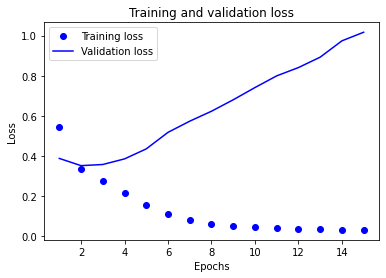

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 학습이 효율적으로 진행되지 않고 있음을 알 수 있습니다.

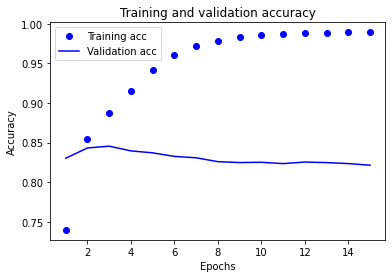

In [27]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- Accuracy 또한 성능이 좋지 않음을 쉽게 알 수 있습니다.

***

### 모델링(RNN)

In [101]:
vocab_size = 10000
word_vector_dim = 100 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 1,119,329
Trainable params: 1,119,329
Non-trainable params: 0
_________________________________________________________________


- 이번에는 RNN 의 LSTM 을 활용해보도록 하겠습니다.

In [102]:
print(X_train.shape)
print(y_train.shape)

(146182, 42)
(146182,)


In [103]:
X_val = X_train[:36182]
y_val = y_train[:36182]

partial_X_train = X_train[36182:]
partial_y_train = y_train[36182:]

# Test
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("partial_X_train.shape:", partial_X_train.shape)
print("partial_y_train.shape:", partial_y_train.shape)

X_val.shape: (36182, 42)
y_val.shape: (36182,)
partial_X_train.shape: (110000, 42)
partial_y_train.shape: (110000,)


- 데이터는 이전과 동일하게 준비하였습니다.

In [104]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

EPOCHS = 10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 4s 13ms/step - loss: 0.4357 - accuracy: 0.7979 - val_loss: 0.3492 - val_accuracy: 0.8472
Epoch 2/10
215/215 [==============================] - 2s 11ms/step - loss: 0.3248 - accuracy: 0.8610 - val_loss: 0.3402 - val_accuracy: 0.8516
Epoch 3/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2925 - accuracy: 0.8757 - val_loss: 0.3333 - val_accuracy: 0.8555
Epoch 4/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2651 - accuracy: 0.8894 - val_loss: 0.3408 - val_accuracy: 0.8564
Epoch 5/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2409 - accuracy: 0.9001 - val_loss: 0.3476 - val_accuracy: 0.8557
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2166 - accuracy: 0.9117 - val_loss: 0.3776 - val_accuracy: 0.8535
Epoch 7/10
215/215 [==============================] - 2s 11ms/step - loss: 0.1953 - accuracy: 0.9208 - val_loss: 0.4135 - val_accuracy: 0.8529

***

### 결과 예측 및 시각화

In [105]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5133 - accuracy: 0.8440
[0.5132989287376404, 0.8440099954605103]


In [106]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


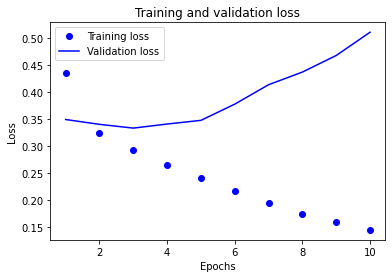

In [107]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- LGBM 모델 또한 성능이 학습이 정상적으로 진행되지 않음을 알 수 있습니다.

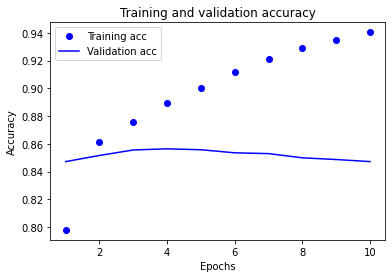

In [108]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- Accuracy 또한 증가하지 않고 있습니다.

***

### 모델링(GlobalMaxPooling1D)

In [63]:
vocab_size = 10000
word_vector_dim = 200 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 2,003,233
Trainable params: 2,003,233
Non-trainable params: 0
_________________________________________________________________


In [64]:
print(X_train.shape)
print(y_train.shape)

(146182, 42)
(146182,)


In [65]:
X_val = X_train[:36182]
y_val = y_train[:36182]

partial_X_train = X_train[36182:]
partial_y_train = y_train[36182:]

# Test
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("partial_X_train.shape:", partial_X_train.shape)
print("partial_y_train.shape:", partial_y_train.shape)

X_val.shape: (36182, 42)
y_val.shape: (36182,)
partial_X_train.shape: (110000, 42)
partial_y_train.shape: (110000,)


- 이전과 동일하게 데이터를 준비해주도록 하겠습니다.

In [66]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

EPOCHS = 10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 2s 5ms/step - loss: 0.4957 - accuracy: 0.7686 - val_loss: 0.3500 - val_accuracy: 0.8473
Epoch 2/10
215/215 [==============================] - 1s 5ms/step - loss: 0.3154 - accuracy: 0.8661 - val_loss: 0.3339 - val_accuracy: 0.8550
Epoch 3/10
215/215 [==============================] - 1s 5ms/step - loss: 0.2651 - accuracy: 0.8919 - val_loss: 0.3418 - val_accuracy: 0.8549
Epoch 4/10
215/215 [==============================] - 1s 4ms/step - loss: 0.2230 - accuracy: 0.9136 - val_loss: 0.3568 - val_accuracy: 0.8533
Epoch 5/10
215/215 [==============================] - 1s 5ms/step - loss: 0.1801 - accuracy: 0.9339 - val_loss: 0.3836 - val_accuracy: 0.8513
Epoch 6/10
215/215 [==============================] - 1s 4ms/step - loss: 0.1370 - accuracy: 0.9533 - val_loss: 0.4200 - val_accuracy: 0.8498
Epoch 7/10
215/215 [==============================] - 1s 5ms/step - loss: 0.0982 - accuracy: 0.9704 - val_loss: 0.4632 - val_accuracy: 0.8459
Epoch 

***

### 결과 예측 및 시각화

In [67]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.6059 - accuracy: 0.8356
[0.6058588624000549, 0.8356083631515503]


In [68]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


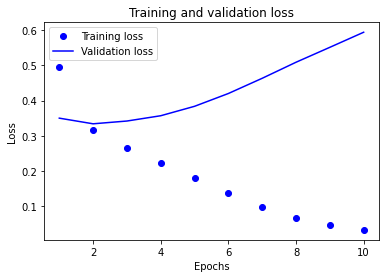

In [69]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

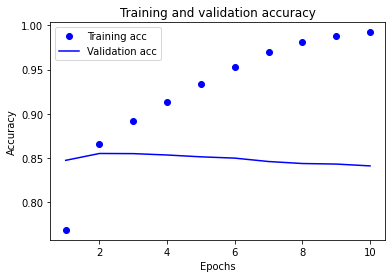

In [70]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- CNN, LGBM, GlobalMaxPooling 세 모델 모두 저조한 성능을 보여주었습니다.
- 밑에서는 GlobalMaxPooling Model 에서 학습된 워드 벡터를 활용해 유사도를 측정해보겠습니다.

***

### GlobalMaxPooling 단어 유사도 측정 (Non-Pretrained)

In [71]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


- embedding layer 에서 학습된 weight 을 불러옵니다.

In [72]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- 각 단어의 벡터를 특수문자 4개를 제외하고 파일로 저장합니다.

In [73]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['굳']
vector

array([-9.12655517e-02, -1.35704160e-01,  5.06590419e-02, -7.70442560e-03,
       -7.34942928e-02, -6.10525683e-02, -1.50803640e-01, -6.58003166e-02,
       -3.02985683e-02,  3.21159102e-02, -3.81114036e-02, -1.00938573e-01,
       -7.59329349e-02, -1.21194318e-01,  2.23400377e-04, -9.20874253e-02,
       -1.04147978e-01,  1.39616534e-01, -9.97068062e-02,  1.52085930e-01,
       -1.39308572e-02, -1.03687845e-01,  6.27857521e-02,  6.74448907e-02,
       -1.74733214e-02, -3.18529718e-02, -1.02607705e-01, -7.50585571e-02,
        3.35333459e-02, -1.65483002e-02,  1.80874914e-01,  6.17588386e-02,
        6.81344047e-02, -9.74009931e-02, -2.71253311e-03,  4.64053592e-03,
       -7.92868882e-02,  8.12322125e-02,  7.91658685e-02,  2.66115330e-02,
        8.50881562e-02, -1.67241674e-02,  6.85513159e-03,  4.98218872e-02,
       -1.26748189e-01, -8.17184001e-02, -1.02100544e-01, -2.18729265e-02,
        9.41389948e-02, -4.24837843e-02,  2.71356646e-02,  4.74903062e-02,
       -6.85254857e-02, -

In [74]:
word_vectors.similar_by_word("굳")

[('귀여움', 0.3358725905418396),
 ('부담없이', 0.3333151340484619),
 ('해요', 0.3137018084526062),
 ('객관적으로', 0.30611735582351685),
 ('주제가', 0.3047097623348236),
 ('아플', 0.30398181080818176),
 ('백', 0.2997032403945923),
 ('중학교', 0.29949820041656494),
 ('바랍니다', 0.29941603541374207),
 ('긔', 0.29913926124572754)]

- "굳" 과 유사도가 높은 단어들을 출력해보았습니다.
- 유사한 단어들을 잘찾아내었다고 생각되지 않습니다.

***

### Pre-trained Model (CNN)

In [75]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector

/tmp/ipykernel_530/1635053418.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [227]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_530/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

- 사전학습된 임베딩 벡터로 "사랑"과 유사한 단어들을 추출해보았습니다.
- 확실히 이전 GlobalMaxPooling 보다 유사도가 높은 단어들이 추출되었습니다.

In [77]:
print(word2vec["사랑"].shape)
print(word2vec["죽음"].shape)

(200,)
(200,)


/tmp/ipykernel_530/3738736718.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(word2vec["사랑"].shape)
/tmp/ipykernel_530/3738736718.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(word2vec["죽음"].shape)


- 사전학습된 워드 벡터의 차원수는 200 임을 알 수 있습니다.

In [78]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_530/2448617487.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_530/2448617487.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


- 사전학습 워드 벡터에서 단어장의 단어들을 찾아 embedding_matrix 에 넣습니다.

In [79]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 42, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 36, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [80]:
X_val = X_train[:36182]
y_val = y_train[:36182]

partial_X_train = X_train[36182:]
partial_y_train = y_train[36182:]

# Test
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("partial_X_train.shape:", partial_X_train.shape)
print("partial_y_train.shape:", partial_y_train.shape)

X_val.shape: (36182, 42)
y_val.shape: (36182,)
partial_X_train.shape: (110000, 42)
partial_y_train.shape: (110000,)


- 동일한 데이터를 준비해주었습니다.

In [81]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
EPOCHS = 20 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
215/215 [==============================] - 2s 8ms/step - loss: 0.5749 - accuracy: 0.6819 - val_loss: 0.4606 - val_accuracy: 0.7835
Epoch 2/20
215/215 [==============================] - 1s 7ms/step - loss: 0.4128 - accuracy: 0.8123 - val_loss: 0.3922 - val_accuracy: 0.8236
Epoch 3/20
215/215 [==============================] - 1s 7ms/step - loss: 0.3458 - accuracy: 0.8501 - val_loss: 0.3802 - val_accuracy: 0.8278
Epoch 4/20
215/215 [==============================] - 1s 7ms/step - loss: 0.3083 - accuracy: 0.8682 - val_loss: 0.3694 - val_accuracy: 0.8363
Epoch 5/20
215/215 [==============================] - 1s 7ms/step - loss: 0.2786 - accuracy: 0.8848 - val_loss: 0.3726 - val_accuracy: 0.8369
Epoch 6/20
215/215 [==============================] - 1s 7ms/step - loss: 0.2533 - accuracy: 0.8968 - val_loss: 0.3874 - val_accuracy: 0.8349
Epoch 7/20
215/215 [==============================] - 1s 7ms/step - loss: 0.2301 - accuracy: 0.9086 - val_loss: 0.4071 - val_accuracy: 0.8341
Epoch 

***

### 결과 예측 및 시각화

In [82]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.9362 - accuracy: 0.8143


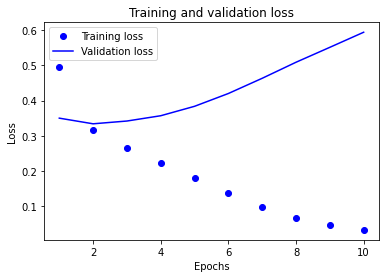

In [83]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

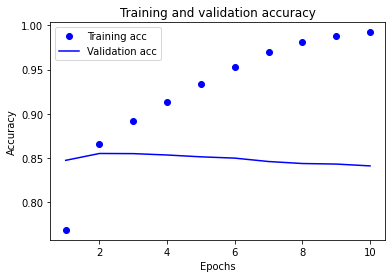

In [84]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- CNN 에서는 사전학습 모델을 사용하지 않았을 때와 사전학습 모델을 사용하였을 때의 성능 차이가 크지 않음을 알 수 있었습니다.

***

### Pre-trained Model (RNN)

In [93]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

- RNN 에서 사용할 한국어 워드임베딩 파일을 다시 불러와주도록 하겠습니다.

In [94]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_530/2448617487.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_530/2448617487.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


- 한국어 임베딩 벡터에서 워드 벡터를 가져와 embedding matrix 에 넣어주었습니다.

In [95]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 42, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


- 사전학습 워드 임베딩을 RNN Model 에 적용시켜보겠습니다.

In [96]:
X_val = X_train[:36182]
y_val = y_train[:36182]

partial_X_train = X_train[36182:]
partial_y_train = y_train[36182:]

# Test
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("partial_X_train.shape:", partial_X_train.shape)
print("partial_y_train.shape:", partial_y_train.shape)

X_val.shape: (36182, 42)
y_val.shape: (36182,)
partial_X_train.shape: (110000, 42)
partial_y_train.shape: (110000,)


- 데이터도 동일하게 준비해주었습니다.

In [97]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

EPOCHS = 10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 5s 16ms/step - loss: 0.4578 - accuracy: 0.7794 - val_loss: 0.3622 - val_accuracy: 0.8395
Epoch 2/10
215/215 [==============================] - 3s 14ms/step - loss: 0.3316 - accuracy: 0.8564 - val_loss: 0.3253 - val_accuracy: 0.8577
Epoch 3/10
215/215 [==============================] - 3s 14ms/step - loss: 0.2871 - accuracy: 0.8791 - val_loss: 0.3240 - val_accuracy: 0.8595
Epoch 4/10
215/215 [==============================] - 3s 14ms/step - loss: 0.2591 - accuracy: 0.8931 - val_loss: 0.3279 - val_accuracy: 0.8605
Epoch 5/10
215/215 [==============================] - 3s 14ms/step - loss: 0.2314 - accuracy: 0.9072 - val_loss: 0.3266 - val_accuracy: 0.8617
Epoch 6/10
215/215 [==============================] - 3s 14ms/step - loss: 0.2042 - accuracy: 0.9195 - val_loss: 0.3385 - val_accuracy: 0.8630
Epoch 7/10
215/215 [==============================] - 3s 15ms/step - loss: 0.1797 - accuracy: 0.9302 - val_loss: 0.3573 - val_accuracy: 0.8609

***

### 결과 예측 및 시각화

In [98]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.5033 - accuracy: 0.8529


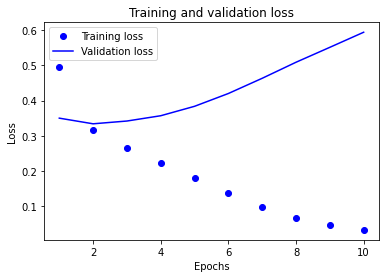

In [99]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

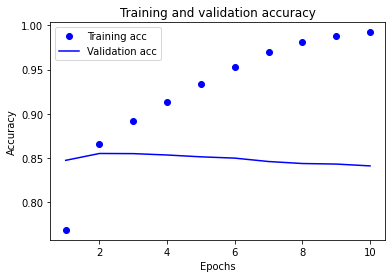

In [100]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 사전학습 모델을 사용하지 않았을 때 보다, test accuracy 가 소폭 상승한 것을 확인할 수 있습니다.
- (loss: 0.5133 - accuracy: 0.8440)  -->  (loss: 0.5033 - accuracy: 0.8529)

***

### Pre-trained Model (GlobalMaxPooling1D)

In [229]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [230]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_530/2448617487.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_530/2448617487.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [231]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 42, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 200)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 17        
Total params: 2,003,233
Trainable params: 2,003,233
Non-trainable params: 0
_________________________________________________________________


- 사전학습된 워드 임베딩을 GlobalMaxPooling1D 모델에 적용시켜 보겠습니다.

In [232]:
X_val = X_train[:36182]
y_val = y_train[:36182]

partial_X_train = X_train[36182:]
partial_y_train = y_train[36182:]

# Test
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("partial_X_train.shape:", partial_X_train.shape)
print("partial_y_train.shape:", partial_y_train.shape)

X_val.shape: (36182, 42)
y_val.shape: (36182,)
partial_X_train.shape: (110000, 42)
partial_y_train.shape: (110000,)


In [233]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

EPOCHS = 10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 2s 6ms/step - loss: 0.7169 - accuracy: 0.5704 - val_loss: 0.6316 - val_accuracy: 0.6452
Epoch 2/10
215/215 [==============================] - 1s 5ms/step - loss: 0.5924 - accuracy: 0.6873 - val_loss: 0.5614 - val_accuracy: 0.7157
Epoch 3/10
215/215 [==============================] - 1s 5ms/step - loss: 0.5304 - accuracy: 0.7404 - val_loss: 0.5114 - val_accuracy: 0.7513
Epoch 4/10
215/215 [==============================] - 1s 5ms/step - loss: 0.4843 - accuracy: 0.7708 - val_loss: 0.4790 - val_accuracy: 0.7708
Epoch 5/10
215/215 [==============================] - 1s 5ms/step - loss: 0.4495 - accuracy: 0.7920 - val_loss: 0.4543 - val_accuracy: 0.7873
Epoch 6/10
215/215 [==============================] - 1s 5ms/step - loss: 0.4225 - accuracy: 0.8078 - val_loss: 0.4372 - val_accuracy: 0.7957
Epoch 7/10
215/215 [==============================] - 1s 5ms/step - loss: 0.4009 - accuracy: 0.8192 - val_loss: 0.4233 - val_accuracy: 0.8054
Epoch 

***

### 결과 예측 및 시각화

In [234]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.4145 - accuracy: 0.8119


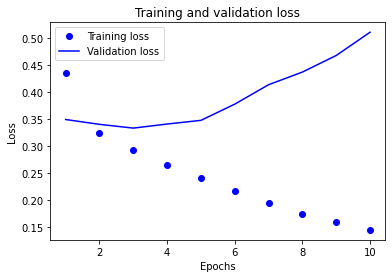

In [235]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

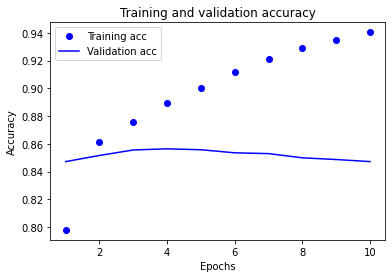

In [236]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 사전학습된 모델을 사용하기 전보다 test accuracy 가 오히려 하락한 것을 볼 수 있습니다.
- (loss: 0.6059 - accuracy: 0.8356)  -->  (loss: 0.4145 - accuracy: 0.8119)
- loss 는 줄어들었지만, accuracy 도 함께 하락한 현상입니다.
- 아래에서는 사전학습된 모델의 워드 벡터로 유사도를 측정해보도록 하겠습니다.

***

### GlobalMaxPooling 단어 유사도 측정 (Pretrained)

In [237]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


- 사전학습된 워드임베딩을 사용한 후, GlobalMaxPooling 모델에서 학습이 잘 되었는지 확인해보도록 하겠습니다.
- embedding_layer 에서 weight 을 불러와주었습니다.

In [238]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_trained.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- 특수문자 4 개를 제외하고 txt 파일로 저장해주었습니다.

In [265]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([ 1.0703063 , -2.2912955 ,  3.559133  , -2.1199276 , -3.0332334 ,
       -0.19465393, -2.481366  , -0.10735121,  2.532727  ,  0.94002855,
       -0.45329845, -2.0046058 , -0.01572813,  0.5299075 ,  0.30947903,
       -0.9715863 , -0.9571187 , -0.60102916,  1.157476  , -1.9047512 ,
       -1.2195476 , -1.1592524 ,  0.6908848 ,  2.0263958 , -0.3389445 ,
       -0.49982402,  1.4806709 , -0.5019951 ,  1.3574295 , -1.1941459 ,
        1.2251973 ,  1.2236094 , -0.30472234,  2.1581662 , -1.1565856 ,
       -0.23786964, -0.6009812 ,  0.4694643 ,  0.82051736, -1.5666542 ,
       -0.02252442, -1.4792949 ,  1.265192  ,  1.4482378 ,  1.570893  ,
        0.6842896 ,  3.1198428 , -1.9629716 ,  0.7421784 ,  1.3782285 ,
        0.4521591 ,  0.4622873 , -2.176243  , -0.20598859, -2.23883   ,
       -1.6937513 , -2.2974951 , -0.46340045,  0.87461954,  0.5414275 ,
        1.4188771 , -0.9991125 , -1.0794336 ,  0.8958367 , -0.8817606 ,
        1.4555601 , -2.426482  ,  0.05825558,  2.4376202 ,  0.37

In [264]:
word_vectors.similar_by_word("좋")

[('괜찮', 0.6817067265510559),
 ('나쁘', 0.6474779844284058),
 ('낫', 0.632419228553772),
 ('알맞', 0.5838558673858643),
 ('낮', 0.5832082033157349),
 ('높', 0.5813097953796387),
 ('많', 0.5619640350341797),
 ('귀찮', 0.5484614372253418),
 ('밝', 0.5327792763710022),
 ('똑같', 0.5149755477905273)]

- 사전학습 모델을 사용하기 전과 비교했을 때 단어 간 유사도가 증가하였다고 볼 수 있습니다.
- 하지만, LSTM 모델을 제외한 다른 두 모델에서는 사전학습 모델을 사용하였음에도 불구하고 0.85 이상의 성능을 보여주지는 못했습니다.

***

# 2.1) Retrospection

<h2 style="font-style:italic">2022.01.21 - [E-06]NaverMovieCorpusSentimentAnalysis</h2>

> 이번 프로젝트에서는 네이버 영화 리뷰 데이터를 활용하여 리뷰가 긍정적(1)인지, 부정적(0)인지를 예측하는 모델을 구현해보았다. 그 과정에서 한국어 워드 임베딩이 완료된 pre-trained data 를 fine-tuning 하여 사용해보기도 하였다.

***

**(1)** **어려웠던 점**
<br>
<br>
- 가장 어려웠던 점은 loss 와 accuracy 최적화였다. pre-trained model 을 사용하지 않고 CNN, RNN, GlobalMaxPooling 3 가지의 모델로 학습을 시켰을 때, loss 와 accuracy 를 시각화한 그래프에서 알 수 있듯이, 학습이 정상적으로 진행되지 못했다.
<br>
<br>
- 그래프를 보았을 때, 공통적으로 epoch 2 에서 3 정도 학습이 진행되었을 때부터 loss 가 갑작스럽게 증가하고, accuracy 가 감소하기 시작한다. 학습이 오래 진행되지 않았음에도 불구하고, train data 와의 간극이 커지며, 성능이 낮아지는 현상은 단순히 오버피팅의 문제라 판단하기에는 그 원인이 불충분해보였다.
<br>
<br>
- 이러한 문제는 pre-trained vector 를 사용하였을 때도 동일하게 나타났다. 미리 학습된 워드 임베딩 벡터를 불러와 미리 생성해놓은 단어장과 매치하여 적절한 벡터값을 embedding matrix 로 생성해주었고, 이를 embedding layer 에서 활용하였을 때도 RNN(LSTM)에서는 0.85 의 accuracy 로 소폭 상향된 모습을 보여주었으나, 그래프와 다른 두 모델에서는 사전학습 모델을 사용하지 않았을 때와 크게 다른 점이 없었다.
<br>
<br>
- non-pre-trained model 과 pre-trained model 을 fine-tuning 하였을 때 성능에 차이가 크게 발생하지 않는다면 데이터의 문제일 확률이 가장 컸다. 애초에 데이터의 전처리가 부족하여 모델이 제대로된 학습을 진행하지 못했던 것이다. 데이터에서 특수문자를 제거하는 시도를 해보려고 했으나, '!' 나 '..' 과 같은 특수문자들은 문장의 학습에 충분히 도움이 될 것 같아 제거하지 않았다.
<br>
<br>
- 또한, 적합한 hyper-parameter 를 찾아내지 못했을 가능성도 있다. 물론 여러 번의 시도 끝에 각 hyper-parameter 별 loss, accuracy 의 변화량을 체크하여 가장 성능이 잘 나오는 방향으로 parameter 를 변경해본 결과이기는 하지만, 가능한 모든 조합을 테스트해보지 않았다는 점에서 학습에 적합한 hyper-parameter 를 찾지 못했을 가능성이 존재한다고 보았다.
<br>
<br>
- 마지막으로, 단어장 내의 단어 개수를 증가시켰다면, 성능이 좋아질 것이라는 생각이 들었다. 이번 프로젝트에서는 10000개의 단어를 기준으로 각 문장들을 텐서로 매핑해주었다. 하지만, 20000개 혹은 30000개의 단어를 가진 큰 규모의 단어장을 생성하여, 각 문장을 매핑한 후, 모델의 hyper-parameter 를 늘려주었다면, 성능이 소폭 상향되었으리라 생각해본다.

**(2)** **알게된 점**
<br>
<br>
- tokenizer 의 morphs 메서드를 굉장히 유용하게 활용할 수 있겠다는 생각이 들었다. 앞서 진행한 RNN 프로젝트에서는 문장을 띄어쓰기를 기준으로  토큰화해주었다. 이렇게 간단한 방식으로 토큰화를 진행할 때에 생길 수 있는 문제점은 각 단어들이 본래의 의미를 잃어버릴 가능성이 농후하다는 것이며, 하나의 의미를 나타내는 다양한 단어들이 다른 class 로 분류될 수 있다는 점이다. 그러나 만약 morphs 메서드와 같이 단어들을 형태소를 기준으로 토큰화해준다면, 단어들이 나누어지면서 본래의 의미를 잃어버리게 되는 문제점을 줄일 수 있으며, 또한 '좋다' 와 '좋은' 과 같이 같은 의미를 나타내지만 종결어미가 다른 단어들 혹은 조사에 따른 차이가 생기는 단어들 모두 적절하게 분류해낼 수 있을 것으로 생각된다. 앞으로 다루게 될 다양한 Text 관련 Classification 에서 유용하게 사용될 토큰화 방법이다.
<br>
<br>
- RNN 에서 각 레이어의 데이터 전달 과정을 알 수 있었다. 입력데이터에 가중치가 곱해지고 활성화 함수를 통과한 값이 다음 레이어에 전달되어 같은 과정을 거친다. 따라서, 출력 레이어에서는 이전에 입력되어 있었던 모든 데이터들이 누적되어 영향을 받게 되고, 이러한 원리에 기반하여 문장을 생성하는 모델도 구현해낼 수 있었던 것이다.
<br>
<br>
- CNN 의 sliding window 기법으로도 text 의 특징을 추출해낼 수 있다는 점을 알게되었다. 이전까지 text 관련한 문제에 있어서는 RNN 이 가장 효율적이며, 적합한 모델이라고 생각해왔는데 Text Classification 에서 CNN 1D 를 사용하여 준수한 성능을 낼 수 있다는 사실을 깨달았다. 특정 문제에 적합한 모델을 찾는 일은 결국 모든 모델에 대해 테스트를 해보기 전에는 알 수 없다는 말이 떠오르는 경험이었다.
<br>
<br>
- 모델의 학습 과정에서 history 에 loss 와 accuracy 를 저장해두고, 이를 시각화하면 적합한 epoch 를 직관적으로 쉽게 찾아낼 수 있다는 점이 흥미로웠다.
<br>
<br>
- 사전학습된 모델을 활용하여 학습을 하였는데도 불구하고, 성능이 예상대로 나와주지 않았다는 점에서 데이터의 중요성과 hyper-parameter 의 중요성을 실감하게 되었다. 적합한 모델과 훌륭한 pre-trained model 을 사용한다고 하더라도, 결국 학습할 데이터의 질이 좋지않고, hyper-parameter 를 찾아내지 못한다면 모델의 성능은 낮게 나올 수 밖에 없다는 점을 알게 되었다.

**(3)** **모호한 점**
<br>
<br>
- 이번 프로젝트에서 어려웠던 점들에 대해서 깊게 학습해나가야 할 것이다. 예를 들면, 데이터 전처리와 적합한 hyper-parameter 를 찾아내는 방법이 되겠다. 모델이 학습할 데이터를 어떠한 방법으로 가공하고, 정규화할지 등 과 같은 방법들에 대해 깊은 이해가 필요할 것 같다. 특히, 수치나 표 형태와 같은 데이터는 물론이고, 텍스트 데이터에 대한 토큰화 방법 및 필터링 방법 또한 깊게 학습해나가야 할 필요성을 느꼈다. 정규표현식에 대한 학습이 더해진다면, 텍스트 데이터를 필터링하고 가공하는 방법에 있어 훨씬 능숙해지지 않을까 생각이 든다.
<br>
<br>
- hyper-parameter 는 매번 공부하고 알아가는데도 항상 부족한 것 같다. 각 개념에 대한 깊은 이해없이 모델 내에서 대충 어떠한 값을 의미하는지 정도만 알고 넘어갔던게 원인이다. hyper-parameter 에 대해 깊게 학습하고, 각 데이터의 특성과 개수 등에 따라 어느 정도의 값이 적합할 것인지 스스로 감을 잡을 수 있는 수준이 되면, hyper-parameter 를 찾아내는 시간들을 아껴 데이터의 전처리에 사용할 수 있을 것 같다. 이전 프로젝트에서 사용해본 grid search 나 random search 에 대해 학습하여 hyper-parameter 를 찾는 시간을 아낄 수 있도록 학습해나갈 생각이다.